In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import preprocessing as pr
from scripts import lstm_model as lm
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from textblob import TextBlob


sns.set_theme(
    rc={
        'grid.linewidth': 0.6, 
        'grid.color': 'white',
        'axes.linewidth': 2, 
        'axes.facecolor': '#ECECEC',
        'axes.labelcolor': '#000000',
        'figure.facecolor': '#f7f7f7',
        'xtick.color': '#000000', 
        'ytick.color': '#000000'
    }
)

In [2]:
# Reading the Parquet file using PyArrow
with open('.\\data\\output_speech_us_central_bank_v2.parquet', 'rb') as handle:
    text = pq.read_table(handle).to_pandas()

text['word_count'] = text['speech_text'].apply(lambda x: len(x.split()))
            
with open('.\\data\\us_macroeconomic_indicators.parquet', 'rb') as handle:
    macroeconomic_indicators = pq.read_table(handle).to_pandas()

In [3]:
preprocessor = pr.TextPreprocessor(
    remove_stopwords=True,
    apply_pos_tagging=True,      # Enable POS tagging
    apply_lemmatization=True     # Enable lemmatization
)

text[['speech_text_processed_text', 'speech_text_word_tokens',
      'speech_text_sent_tokens', 'speech_text_word_tokens_wo_stopwords',
      'speech_text_pos_tags']] = preprocessor.preprocess_dataframe(text, 'speech_text')

text.dropna(inplace=True)

text['processed_speech_text'] = text['speech_text_word_tokens_wo_stopwords'].apply(' '.join)

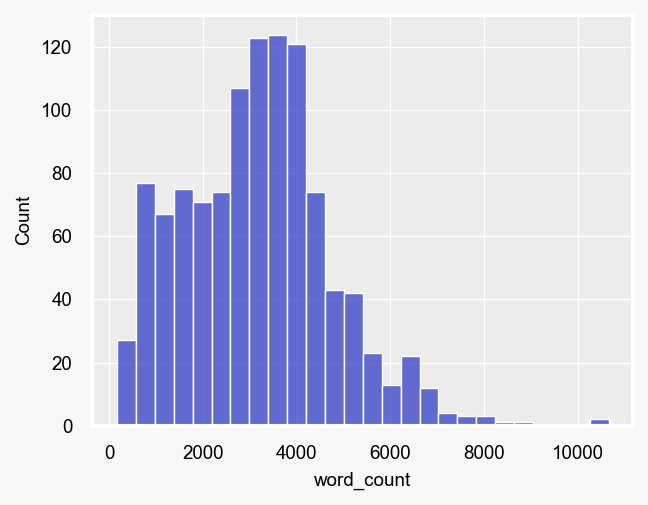

In [7]:
with plt.rc_context(rc={'figure.dpi': 150, 
                        'axes.labelsize': 9, 
                        'xtick.labelsize': 9, 'ytick.labelsize': 9,
                        'legend.fontsize': 9, 'legend.title_fontsize': 9}):

    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
    
    # Biplots
    sns.histplot(ax=ax[0], x=text['word_count'], color='#323fc9')

    ax[1].set_visible(False)
    ax[2].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

In [4]:
# Word vocabulary
word_tokens = text['speech_text_word_tokens_wo_stopwords'].dropna().tolist()
all_word_tokens = [token for sublist in word_tokens for token in sublist]
word2idx = lm.build_vocab(all_word_tokens, max_vocab_size=50000, min_freq=5)
vocab_size = len(word2idx)

print(f"Vocabulary size: {vocab_size}")

# Create Embedding Matrix
embedding_index = {}
with open('data/embeddings/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word2idx.items():  # iterates through each word in the vocabulary (which is created before)
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Vocabulary size: 10898


In [5]:
# Calculate word frequencies
word_freq = Counter(all_word_tokens)
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))
words = list(sorted_word_freq.keys())
frequencies = list(sorted_word_freq.values())

# Filter out some words
filtered_dict = {key: value for key, value in sorted_word_freq.items() if value >= 100}

keys_to_exclude = {'.', '--', '..', 'also', 'may', 'year', 'one', 'since', 'today', 'could', 'take'}
filtered_dict = {key: value for key, value in filtered_dict.items() if key not in keys_to_exclude}

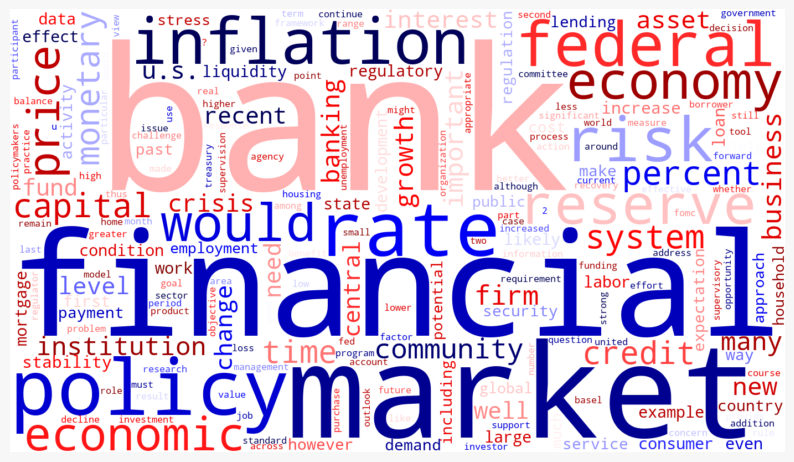

In [107]:
wordcloud = WordCloud(width=1400, height=800, background_color='white',
                      colormap='seismic').generate_from_frequencies(filtered_dict)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.show()

In [19]:
embeddings = []
col_names = []

for word, freq in filtered_dict.items():
    if freq >= 100:
        if embedding_index.get(word) is not None:
            col_names.append(word)
            embeddings.append(embedding_index.get(word))

embeddings = pd.DataFrame(embeddings, index=col_names, columns=[f'dim {x}' for x in range(1, 101)])
embeddings = embeddings.reset_index()

In [7]:
# TextBlob
def classify_sentiment(word):
    blob_word = TextBlob(word)
    if blob_word.sentiment.polarity > 0:
        return "positive"
    elif blob_word.sentiment.polarity < 0:
        return "negative"
    else:
        return "neutral"


moods = {word: classify_sentiment(word) for word in embeddings.index}

In [47]:
# Add word sentiment
embeddings['mood'] = embeddings['index'].map(moods)

In [48]:
# PCA
embeddings_ = embeddings.loc[:, [x for x in embeddings.columns if 'dim' in x]]
pca_pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=embeddings_.shape[1]))])
pca_result = pca_pipeline.fit_transform(embeddings_)
pca = pca_pipeline.named_steps['pca']

pca_columns = pd.DataFrame(pca_result, columns=[f'PC {x}' for x in range(1, embeddings_.shape[1] + 1)])
pca_columns['mood'] = embeddings['mood'] 
# pca_columns = pca_columns[pca_columns['mood'] != 'neutral']

explained_variance = pca.explained_variance_ratio_ * 100